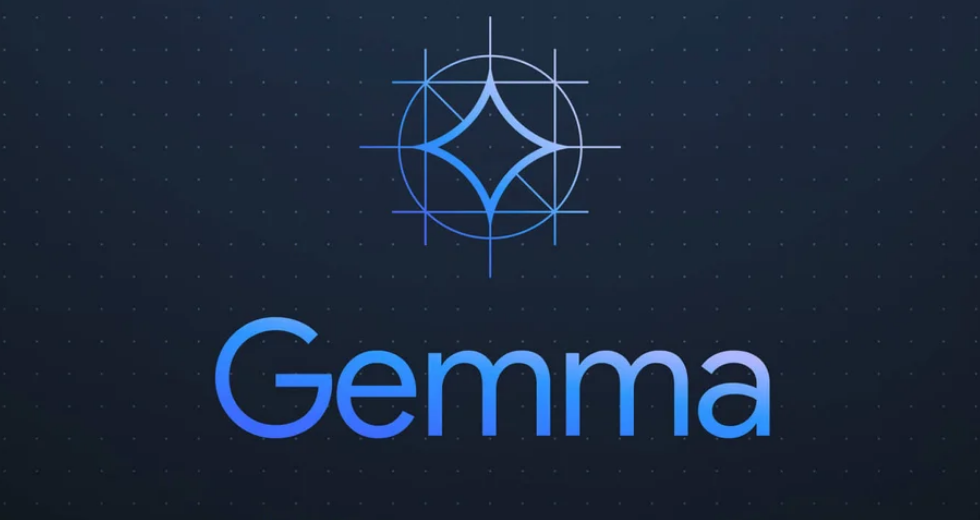

# **We will do QA in 3 steps: <br/> <br/>**

## **1. First we try QA on the Loaded model with suitable prompt without Finetune**

## **2. Fintune Gemma for our QA task and see the results**

## **3. Use RAG for context fetching with given Query and see the results with Finetuned Gemma**

In [ ]:
!pip install --quiet transformers
!pip install --quiet pytorch-lightning
!pip install --quiet peft
!pip install --quiet sentencepiece
!pip install --quiet datasets
!pip install --quiet accelerate
!pip install --quiet bitsandbytes
!pip install --quiet openpyxl
!pip install --quiet evaluate
!pip install --quiet einops
!pip install --quiet langchain
!pip install --quiet xformers
!pip install --quiet sentence_transformers
!pip install --quiet chromadb

In [ ]:
import json
import pandas as pd
import numpy as np
from transformers import BitsAndBytesConfig
from pathlib import Path
from datasets import load_dataset
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from sklearn.model_selection import train_test_split
from termcolor import colored
import textwrap

In [ ]:
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint

## **Load the QA Dataset**

In [ ]:
path = '/kaggle/input/newsqa/NewsQA.feather'

In [ ]:
df = pd.read_feather(path)
df.head(5)

In [ ]:
df = df.iloc[:500]

In [ ]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForCausalLM, DataCollatorWithPadding

# **Gemma 2b instruct**

## **1. First we try QA on the Loaded model with suitable prompt and see the Results** 

## **Load the Model and Tokenizer**

In [ ]:
MODEL_NAME = "/kaggle/input/gemma/transformers/2b-it/2"

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

In [ ]:
model_config = transformers.AutoConfig.from_pretrained(MODEL_NAME)

### **Config to Load the Model**

In [ ]:
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=bfloat16,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
)

In [ ]:
init_model = AutoModelForCausalLM.from_pretrained(MODEL_NAME,
                                              trust_remote_code=True,
                                              config=model_config,
                                              quantization_config=quantization_config,
                                              device_map='auto')
                                                           

### **Function to Generate Suitable prompt for QA**

In [ ]:
def prompt_gen(ques,context):
    instruct = "Give precise Answer within 5 words to the Question from the Context if it is not None"
    
    template = "Question:\n{question}\n\nContext:\n{context}\n\nInstruction:\n{instruction}\n\nAnswer:\n{answer}"
    
    prompt = template.format(
        question = ques,
        context = context,
        instruction = instruct,
        answer = ""
    )
    
    return prompt

## **Function will output Answer for given prompt with context**

In [ ]:
def get_answer(idx,model):
    
    ques = df.iloc[idx]['question']
    context = df.iloc[idx]['paragraph']
    
    print(f"\n\nActual : {df.iloc[idx]['answer']}\n")
    
    prompt =  prompt_gen(ques,context)
    
    input_ids = tokenizer(prompt, return_tensors="pt")
    outputs = model.generate(**input_ids,max_new_tokens=5)
    print(tokenizer.decode(outputs[0],skip_special_tokens=True,clean_up_tokenization_spaces=True))

In [ ]:
get_answer(5,init_model)

In [ ]:
get_answer(20,init_model)

## **Verict : So as we can see Gemma is not performing well for our QA task. So we'll Fintune the model and see the results**

In [ ]:
train_df, val_df = train_test_split(df,test_size=0.1)

## **Preparing the Dataset and the Dataloader for the Training**

In [ ]:
class NQADataset(Dataset):
  def __init__(self,data : pd.DataFrame,tokenizer : tokenizer,source_max_token_len : int = 300,target_max_token_len : int = 300):

    self.tokenizer = tokenizer
    self.data = data
    self.source_max_token_len = source_max_token_len
    self.target_max_token_len = target_max_token_len

  def __len__(self):
    return len(self.data)
  
  def __getitem__(self,index : int):
    data_row = self.data.iloc[index]
    
    template = "Question:\n{question}\n\nContext:\n{context}\n\nInstruction:\n{instruction}\n\nAnswer:\n{answer}"

    instruct = "Give precise Answer within 5 words to the Question from the Context if it is not None"

    prompt = template.format(
        question = data_row['question'],
        context = data_row['paragraph'],
        instruction = instruct,
        answer = "")


    source_encoding = tokenizer(
        prompt,
        max_length = self.source_max_token_len,
        padding = "max_length",
        truncation = True,
        return_attention_mask = True,
        add_special_tokens = True,
        return_tensors = "pt")
    
    target_encoding = tokenizer(
        data_row['answer'],
        max_length = self.target_max_token_len,
        padding = "max_length",
        truncation = True,
        add_special_tokens = True,
        return_tensors = "pt")
    
    labels = target_encoding["input_ids"]
    labels[labels == 0] = -100

    return dict(
        input_ids = source_encoding['input_ids'].flatten(),
        attention_mask = source_encoding['attention_mask'].flatten(),
        labels = labels.flatten())

In [ ]:
class NQADataModule(pl.LightningDataModule):
  def __init__(self,train_df : pd.DataFrame,test_df : pd.DataFrame,tokenizer : tokenizer,batch_size : int = 8,source_max_token_len : int = 300,target_max_token_len : int = 300):
    super().__init__()
    self.batch_size = batch_size
    self.train_df = train_df
    self.test_df = test_df
    self.tokenizer = tokenizer
    self.source_max_token_len = source_max_token_len
    self.target_max_token_len = target_max_token_len

  def setup(self,stage=None):
    self.train_dataset = NQADataset(self.train_df,self.tokenizer,self.source_max_token_len,self.target_max_token_len)
    self.test_dataset = NQADataset(self.test_df,self.tokenizer,self.source_max_token_len,self.target_max_token_len)

  def train_dataloader(self):
    return DataLoader(self.train_dataset,batch_size = self.batch_size,shuffle=True,num_workers=4)

  def val_dataloader(self):
    return DataLoader(self.test_dataset,batch_size = 1,num_workers=4)

  def test_dataloader(self):
    return DataLoader(self.test_dataset,batch_size = 1,num_workers=4)

In [ ]:
BATCH_SIZE = 4

data_module = NQADataModule(train_df,val_df,tokenizer,batch_size = BATCH_SIZE)
data_module.setup()

In [ ]:
data_module.train_dataset

In [ ]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
import torch
from torch import cuda, bfloat16
import transformers
from peft import LoraConfig, get_peft_model, TaskType

## **We'll use LoRA to Finetune Gemma**

In [ ]:

config = LoraConfig(
    r=8, #attention heads
    lora_alpha=16, #alpha scaling
    lora_dropout=0.05,
    bias="none",
    task_type=TaskType.CAUSAL_LM,
    target_modules=["q_proj", "o_proj", "k_proj", "v_proj", "gate_proj", "up_proj", "down_proj"]
)
  

In [ ]:
model = get_peft_model(init_model, config)


In [ ]:
model.print_trainable_parameters()

## **Trainable params = 9,805,824 <br /> Total params = 2,515,978,240 <br /> Trainable % =  0.3897420034920493**


## As we are Finetuning Gemma for Specific Task(QA), So few no. of parameters need to be updated.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

In [ ]:
pl.seed_everything(42)

In [ ]:
training_args = transformers.TrainingArguments(
    output_dir="my_awesome_model",
    learning_rate=2e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=5,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True
)

In [ ]:
trainer = transformers.Trainer(
    model=model.to(device),
    train_dataset = data_module.train_dataset,
    eval_dataset = data_module.test_dataset,
    args=training_args,
    tokenizer=tokenizer,
    data_collator=data_collator
)

In [ ]:
trainer.train()

In [ ]:
trainer.state.log_history

## **2. Now we'll see the results after fintuning** 

In [ ]:
get_answer(50,model)

In [ ]:
get_answer(5,model)

In [ ]:
get_answer(20,model)

## **Verdict : As we can see Gemma is performing well for our QA task after finetunig**

## **3. Now instead of providing the context directly, we'll try to fetch the context from VectorDB for a given Query(Question)**

# **RAG**

### **3.a : Spliiting the context text before generating the Embeddings**

In [ ]:
from langchain.document_loaders import TextLoader
from langchain.text_splitter import SentenceTransformersTokenTextSplitter,TokenTextSplitter
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.chains import RetrievalQA
from langchain.vectorstores import Chroma

In [ ]:
from langchain_community.document_loaders import DataFrameLoader


In [ ]:
loader = DataFrameLoader(df, page_content_column="paragraph")


In [ ]:
documents = loader.load()


In [ ]:
!pip install --quiet tiktoken

In [ ]:
text_splitter = SentenceTransformersTokenTextSplitter(chunk_size=25, chunk_overlap=5)
all_splits = text_splitter.split_documents(documents)

### **3.b : Generate Embeddings on splitted text using SentenceTransformer**

In [ ]:
model_name = "sentence-transformers/all-mpnet-base-v2"
model_kwargs = {"device": "cuda"}

embeddings = HuggingFaceEmbeddings(model_name=model_name, model_kwargs=model_kwargs)

### **3.c : Storing the Embeddings in CromaDB**

In [ ]:
vectordb = Chroma.from_documents(documents=all_splits, 
                                 embedding=embeddings, 
                                 persist_directory="chroma_db")

### **Specifying no of docs it will return for a given query**

In [ ]:
retriever = vectordb.as_retriever(search_kwargs={"k": 5})


In [ ]:
query = df.iloc[6]['question']

In [ ]:
rev = retriever.get_relevant_documents(query)


In [ ]:
res_context = "".join([i.page_content for i in rev])

In [ ]:
print(res_context)

## **Now we see the Results of QA with our Finetuned Gemma with RAG**

In [ ]:

def get_answerRAG(idx,model):
    
    ques = df.iloc[idx]['question']
    
    rev = retriever.get_relevant_documents(ques)
    res_context = "".join([i.page_content for i in rev])
    
    print(f"\n\nActual : {df.iloc[idx]['answer']}\n")
    
    prompt =  prompt_gen(ques,context)
    
    input_ids = tokenizer(prompt, return_tensors="pt")
    outputs = model.generate(**input_ids,max_new_tokens=5)
    print(tokenizer.decode(outputs[0],skip_special_tokens=True,clean_up_tokenization_spaces=True))



In [ ]:
get_answerRAG(6,model)

In [ ]:
get_answerRAG(5,model)

In [ ]:
get_answerRAG(50,model)

## **Verdict : So from the Generated Answer we can see, we are getting correct context from CromaDB for given Query and Gemma able to produce Correct Answers**